## Mahjong Tile Detection Inference Demos

In [3]:
import os
from inference_sdk import InferenceHTTPClient, InferenceConfiguration

class MahjongInference:
    def __init__(self, api_key, model_id, test_image_dir=None):
        self.test_image_dir = test_image_dir
        self.api_key = api_key
        self.model_id = model_id
        self.image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
        if test_image_dir:
            self.image_files = self.get_image_files_from_directory(test_image_dir)

        self.CLIENT = InferenceHTTPClient(
            api_url="https://detect.roboflow.com",
            api_key=self.api_key
        )
        self.custom_configuration = InferenceConfiguration(confidence_threshold=0.5, max_detections=14)
        self.CLIENT.configure(self.custom_configuration)
        # self.result = None

    def infer(self):
        return self.CLIENT.infer(self.image_files, model_id=self.model_id)

    def infer_single_image(self, image_path):
        return self.CLIENT.infer([image_path], model_id=self.model_id)
    
    def infer_directory(self, directory_path):
        image_files = self.get_image_files_from_directory(directory_path)
        return self.CLIENT.infer(image_files, model_id=self.model_id)

    def get_image_files_from_directory(self, directory_path):
        files_in_directory = os.listdir(directory_path)
        return [os.path.join(directory_path, file) for file in files_in_directory if os.path.splitext(file)[1].lower() in self.image_extensions and "annotated" not in file]
    

# Create an instance of the MahjongInference class
engine = MahjongInference(test_image_dir='test_real_images', api_key='oWpTxAssNuM3zAlX4vlP', model_id='riichi-mahjong-detection/3')



In [5]:
from mahjong.hand_calculating.hand import HandCalculator
from mahjong.tile import TilesConverter
from mahjong.hand_calculating.hand_config import HandConfig
from mahjong.meld import Meld
from collections import defaultdict
from mahjong.shanten import Shanten

class MahjongScorer:
    def __init__(self):
        self.calculator = HandCalculator()
        self.config = HandConfig(is_tsumo=False, is_riichi=False, player_wind='east', round_wind='east')
        self.dora_indicators = ""
        
    def update_config(self, config):
        self.config = config
    
    def update_dora_indicators(self, dora_indicators):
        self.dora_indicators = dora_indicators
    
    def parse_hand_string(self, hand):
        hand_dict = defaultdict(list)
        for tile in hand:
            if "m" in tile:
                hand_dict["m"].append(tile[0])
            elif "p" in tile:
                hand_dict["p"].append(tile[0])
            elif "s" in tile:
                hand_dict["s"].append(tile[0])
            elif "z" in tile:
                hand_dict["z"].append(tile[0])
        return "".join(
                    ["".join(tile_numbers) + tile_type for tile_type, tile_numbers in hand_dict.items()]
                )
        
    def parse_hand(self, hand, parse_type=136):
        if type(hand) == str:
            return TilesConverter.one_line_string_to_136_array(string=hand)
        elif type(hand) == list:

            if parse_type == 136:
                return TilesConverter.one_line_string_to_136_array(string=self.parse_hand_string(hand))
            else:
                return TilesConverter.one_line_string_to_34_array(string=self.parse_hand_string(hand))
    
    def str_repr_hand(self, hand):
        return self.parse_hand_string(hand)

    def hand_score(self, hand, win_tile, verbose=True):
        tiles = self.parse_hand(hand)
        parsed_win_tile = self.parse_hand(win_tile)[0]
        dora_indicators_array = TilesConverter.one_line_string_to_136_array(string=self.dora_indicators)
        # print(f"Hand is: {hand}, winning_tile is: {win_tile}, dora_indicators are: {self.dora_indicators}")
        result = self.calculator.estimate_hand_value(tiles, parsed_win_tile, config=self.config, dora_indicators=dora_indicators_array)
        if not result.error: # if winning hand calc
            if verbose:
                print("你的手牌是: ", self.str_repr_hand(hand))
                print(f"{result.cost['yaku_level']} 番数: {result.han}, 符数: {result.fu}")
                print(result.cost['total'])
                # print("Score Breakdown:\n")
                # for k, v in result.cost.items():
                #     print(f"{k}: {v}")
                print(result.yaku)
                for fu_item in result.fu_details:
                    print(fu_item)
                print("Cong!\n")
            return (result.cost['total'], result)
        else:
            if verbose:
                print("ERROR", result.error)
            return -1, None

    def calculate_shanten(self, hand):
        shanten = Shanten()
        tiles = self.parse_hand(hand, parse_type=34)
        return shanten.calculate_shanten(tiles)
    
    def can_win(self, hand, win_tile):
        score, full_score = self.hand_score(hand, win_tile, verbose=False)
        return score, full_score
            
    def calculate_tenpai_tiles(self, hand):
        full_tile_set = ["1m", "2m", "3m", "4m", "5m", "6m", "7m", "8m", "9m",
                "1p", "2p", "3p", "4p", "5p", "6p", "7p", "8p", "9p",
                "1s", "2s", "3s", "4s", "5s", "6s", "7s", "8s", "9s",
                "1z", "2z", "3z", "4z", "5z", "6z", "7z"]
        winning_tiles = []
        for tile in full_tile_set:
            # Test if adding the current tile would make the hand tenpai
            curr_hand = hand + [tile]
            score, full_score = self.can_win(curr_hand, [tile])
            if score != -1:
                winning_tiles.append((score, tile, full_score.cost['yaku_level'], full_score.han, full_score.fu, full_score.yaku))
        
        return sorted(winning_tiles, reverse=True)

    def print_possible_wins(self, winning_tiles):
        if len(winning_tiles) == 0:
            print("\t\t无役 别搞了!")
        for res in winning_tiles:
            print(f"\t\t听牌: {res[1]}, 役: {res[5]}, 分数: {res[0]} {res[2]}, 番数: {res[3]}, 符数: {res[4]}")
    
    def list_all_possible_wins(self, hand):
        print("听牌! 你的手牌是: ", self.str_repr_hand(hand))
        winning_tiles = self.calculate_tenpai_tiles(hand)
        # return winning_tiles
        print("\t如果默听荣和")
        self.print_possible_wins(winning_tiles)
        
        tmp_is_tsumo = self.config.is_tsumo
        tmp_is_riichi = self.config.is_riichi
        tmp_player_wind = self.config.player_wind
        
        print("\t如果自摸")
        self.config.is_tsumo = True
        winning_tiles = self.calculate_tenpai_tiles(hand)
        # return winning_tiles
        self.print_possible_wins(winning_tiles)
        self.config.is_tsumo = tmp_is_tsumo
        
        print("\t如果立直荣和")
        self.config.is_riichi = True
        winning_tiles = self.calculate_tenpai_tiles(hand)
        # return winning_tiles
        self.print_possible_wins(winning_tiles)
        self.config.is_riichi = tmp_is_riichi
        
        print("\t如果立直自摸")
        self.config.is_riichi = True
        self.config.is_tsumo = True
        winning_tiles = self.calculate_tenpai_tiles(hand)
        # return winning_tiles
        self.print_possible_wins(winning_tiles)
        self.config.is_tsumo = tmp_is_tsumo
        self.config.is_riichi = tmp_is_riichi
        print("GLHF\n")
            
    def process_hand(self, hand, win_tile=None, dora_indicators=None):
        self.update_dora_indicators(dora_indicators)
        if len(hand) == 14:
            self.hand_score(hand, win_tile)
        elif len(hand) == 13:
            shanten = self.calculate_shanten(hand)
            if shanten == 0:
                self.list_all_possible_wins(hand)
            else:
                print(f"Shanten: {shanten}")
        else:
            print("Invalid hand length")
    

In [6]:
scorer = MahjongScorer()
scorer.process_hand(['2m', '2m', '2m', '3p', '3p', '7p', '7p', '7p', '4s', '4s', '4s', '7s', '8s'], dora_indicators="9m")
scorer.process_hand(['1m', '1m', '1m', '3p', '3p', '3p', '7p', '7p', '7p', '4s', '4s', '4s', '2z', '2z'], 
                    win_tile="3p",
                    dora_indicators="9m")

听牌! 你的手牌是:  222m33777p44478s
	如果默听荣和
		听牌: 6s, 役: [Tanyao, San Ankou], 分数: 6400 , 番数: 3, 符数: 50
		听牌: 9s, 役: [San Ankou], 分数: 3200 , 番数: 2, 符数: 50
	如果自摸
		听牌: 6s, 役: [Menzen Tsumo, Tanyao, San Ankou], 分数: 8000 mangan, 番数: 4, 符数: 40
		听牌: 9s, 役: [Menzen Tsumo, San Ankou], 分数: 5200 , 番数: 3, 符数: 40
	如果立直荣和
		听牌: 6s, 役: [Riichi, Tanyao, San Ankou], 分数: 8000 mangan, 番数: 4, 符数: 50
		听牌: 9s, 役: [Riichi, San Ankou], 分数: 6400 , 番数: 3, 符数: 50
	如果立直自摸
		听牌: 9s, 役: [Menzen Tsumo, Riichi, San Ankou], 分数: 8000 mangan, 番数: 4, 符数: 40
		听牌: 6s, 役: [Menzen Tsumo, Riichi, Tanyao, San Ankou], 分数: 8000 mangan, 番数: 5, 符数: 40
GLHF

你的手牌是:  111m333777p444s22z
haneman 番数: 7, 符数: 50
12000
[Toitoi, San Ankou, Dora 3]
{'fu': 30, 'reason': 'base'}
{'fu': 8, 'reason': 'closed_terminal_pon'}
{'fu': 4, 'reason': 'closed_pon'}
{'fu': 4, 'reason': 'closed_pon'}
{'fu': 2, 'reason': 'open_pon'}
Cong!



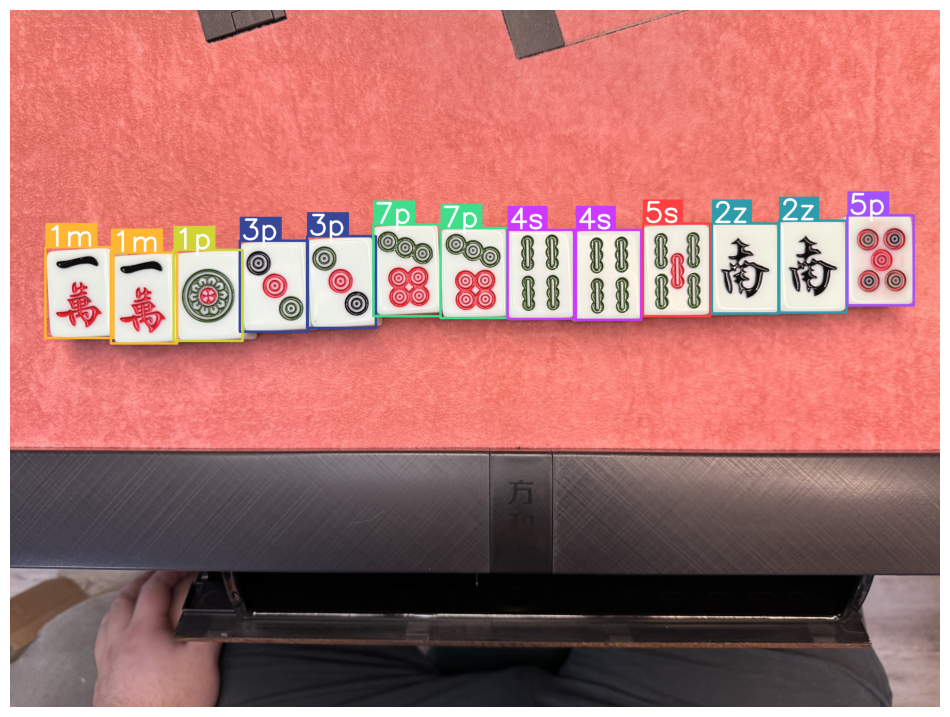

test_real_images/IMG_2788.JPG ['1m', '1m', '1p', '3p', '3p', '5p', '7p', '7p', '4s', '4s', '5s', '2z', '2z'] 13
Shanten: 1


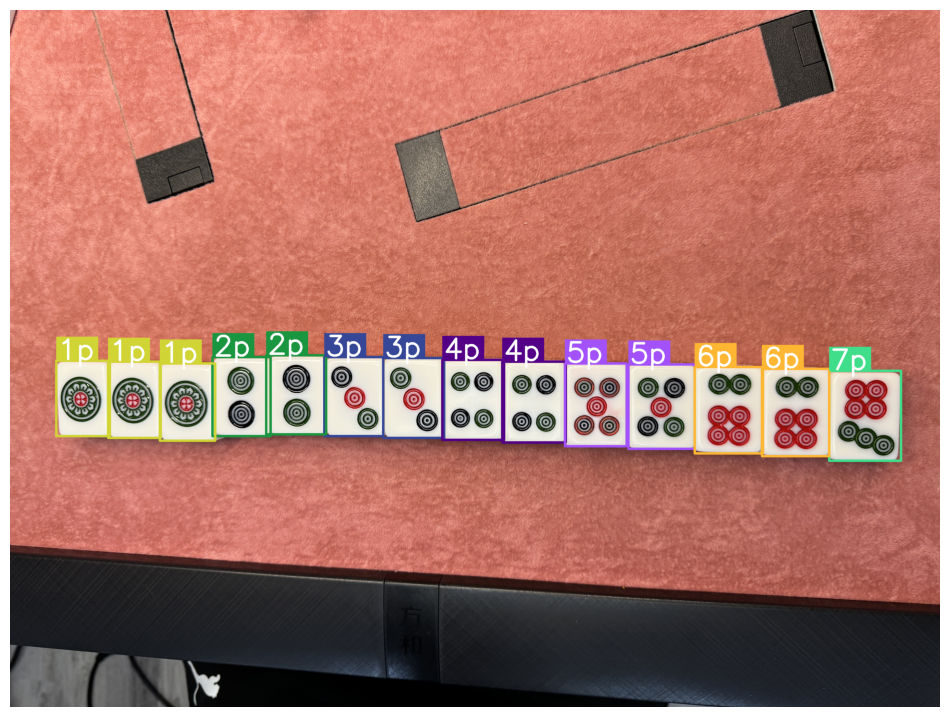

test_real_images/IMG_2781.JPG ['1p', '1p', '1p', '2p', '2p', '3p', '3p', '4p', '4p', '5p', '5p', '6p', '6p', '7p'] 14
你的手牌是:  11122334455667p
haneman 番数: 7, 符数: 30
12000
[Pinfu, Chinitsu]
{'fu': 30, 'reason': 'base'}
Cong!



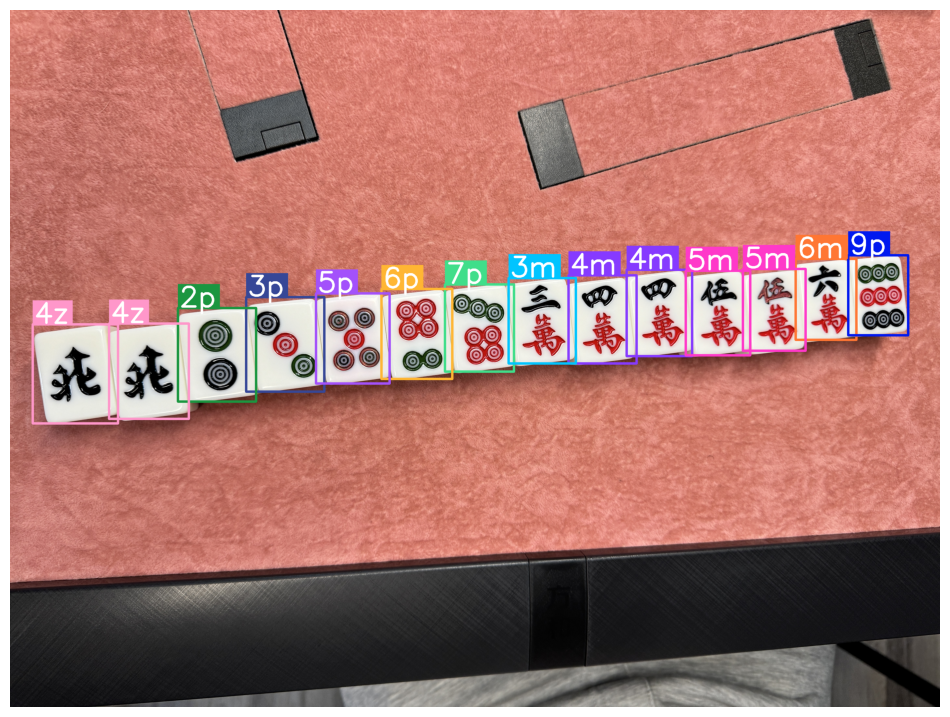

test_real_images/IMG_2780.JPG ['3m', '4m', '4m', '5m', '5m', '6m', '2p', '3p', '5p', '6p', '7p', '9p', '4z', '4z'] 14
ERROR hand_not_winning


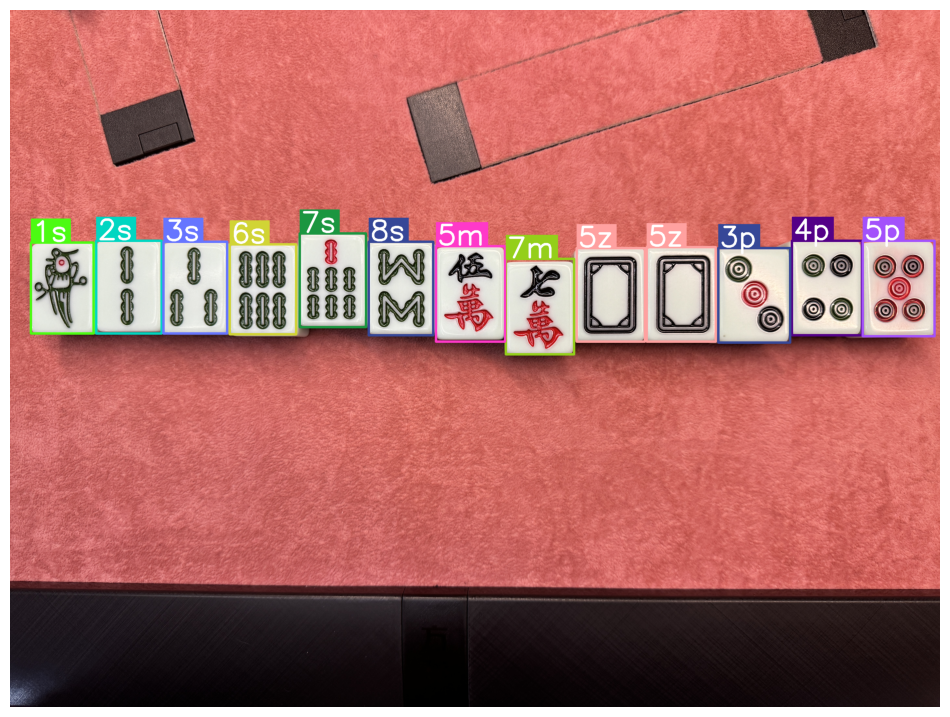

test_real_images/IMG_2783.JPG ['5m', '7m', '3p', '4p', '5p', '1s', '2s', '3s', '6s', '7s', '8s', '5z', '5z'] 13
听牌! 你的手牌是:  57m345p123678s55z
	如果默听荣和
		无役 别搞了!
	如果自摸
		听牌: 6m, 役: [Menzen Tsumo], 分数: 1100 , 番数: 1, 符数: 30
	如果立直荣和
		听牌: 6m, 役: [Riichi], 分数: 1300 , 番数: 1, 符数: 40
	如果立直自摸
		听牌: 6m, 役: [Menzen Tsumo, Riichi], 分数: 2000 , 番数: 2, 符数: 30
GLHF



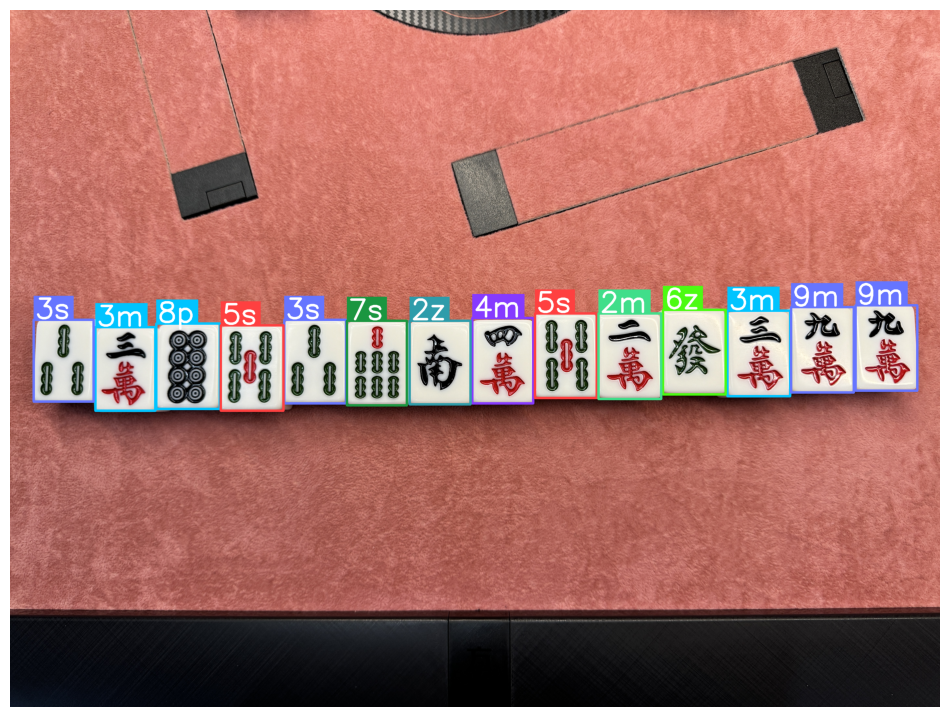

test_real_images/IMG_2778.JPG ['2m', '3m', '3m', '4m', '9m', '9m', '8p', '3s', '3s', '5s', '5s', '7s', '2z', '6z'] 14
ERROR hand_not_winning


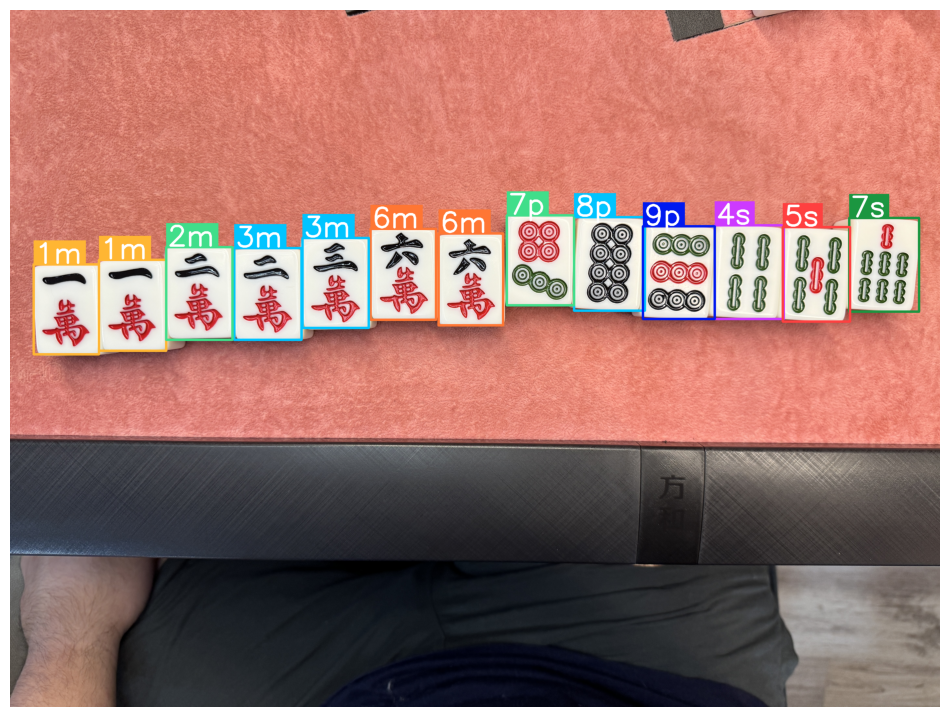

test_real_images/IMG_2786.JPG ['1m', '1m', '2m', '3m', '3m', '6m', '6m', '7p', '8p', '9p', '4s', '5s', '7s'] 13
Shanten: 1


In [8]:
import cv2
import supervision as sv
from inference.models.utils import get_roboflow_model
class ImageProcessor:
    def __init__(self, image_files, result):
        self.image_files = image_files
        self.result = result
        self.mahJongScorer = MahjongScorer()

    def get_scale_factor(self, image_size, reference_size=800, base_scale=0.8, base_thickness=2):
        # Calculate the scale factor based on the image size compared to a reference size
        scale_factor = max(image_size) / reference_size
        scaled_text_scale = max(base_scale * scale_factor, base_scale)  # Ensure minimum scale
        scaled_text_thickness = max(int(base_thickness * scale_factor), base_thickness)  # Ensure minimum thickness
        return scaled_text_scale, scaled_text_thickness

    def process_images(self):
        for img, resp in zip(self.image_files, self.result):
            image = cv2.imread(img)
            # Get scale and thickness based on image size
            text_scale, text_thickness = self.get_scale_factor(image.shape[:2])

            detections = sv.Detections.from_inference(resp)
            bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=text_thickness)
            label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=text_thickness)
            # conf_annotator = sv.PercentageBarAnnotator()

            annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
            annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
            # annotated_image = conf_annotator.annotate(scene=annotated_image, detections=detections)
            sv.plot_image(annotated_image)
            hand = sorted([pred['class'] for pred in resp['predictions']], key=lambda x: (x[1], x[0]))
            print(img, hand, len(hand))
            self.mahJongScorer.process_hand(hand, hand[0], [])
            # except Exception as e:
            #     print("Cannot score hand or calculaute shanten", e)

# Create an instance of the ImageProcessor class
processor = ImageProcessor(engine.image_files, result=engine.infer())
# Call the process_images method to process the images
processor.process_images()
